In [3]:
import numpy as np
import random
import sklearn
from sklearn.datasets.samples_generator import make_regression 
import pylab
from scipy import stats
import matplotlib.pyplot as plt
import math
from tqdm import tqdm


#(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x = np.random.rand(10, 5)
y = np.random.rand(10, 6)

main loop: 100%|██████████| 6000/6000 [00:18<00:00, 321.88it/s]


Max interactions exceeded!


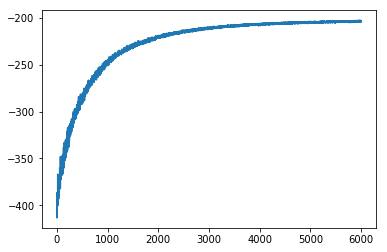

In [26]:
# dimensions for the NN:
# input dimension
N = x.shape[0] # 10
Q = x.shape[1] # 5
# hidden layer dimension
K = 100
# output dimension 
D = y.shape[1] # 6

#1 - p1 : probability of dropping a line of the weight matrix


def gradient_descent_dropout(x, y, p1, p2, sigma, tau, ep=0.0001, max_iter=10000):
    
    res = []
    converged = False
    iter = 0
    N = x.shape[0] # number of samples
    Q = x.shape[1]

    
    # initial weight matrices 
    M1 = np.random.normal(Q, K)
    M2 = np.random.rand(K, D)                                                                                                              
    m = np.random.rand(1, K)
    
    for _ in tqdm(range(max_iter), desc="main loop"):        
        
        z1v = np.zeros((Q,N))
        z2v = np.zeros((K,N))
    
        for i in range(N):
            z1v[:,i] = np.random.binomial(size=Q, n=1, p= p1)
            z2v[:,i] = np.random.binomial(size=K, n=1, p= p2)
        
        # Objective loss
        L_GP_MC = - p1*np.linalg.norm(M1)**2 - p2*np.linalg.norm(M2)**2 - np.linalg.norm(m)**2
    
    
        for i in range(N):
            #Bernoulli vectors for dropouts
            z1 = np.diag(z1v[:,i])
            z2 = np.diag(z2v[:,i])
        
            # Computing prediction for the x
            y_pred = (1/K)**(1/2)*sigma*np.matmul(np.maximum(0,(np.matmul(x[i],np.matmul(z1,M1))+m)),np.matmul(z2,M2))
            ynew =  y_pred - y[i] 
            L_GP_MC -= tau*np.linalg.norm(ynew)**2
            
        
        gradM1 = np.zeros((Q, K))
        gradM2 = np.zeros((K, D))
        gradm = np.zeros((1,K))
            
        for j in range(0,K):
            ps = np.dot(M2[j], ynew[0])
            tmp = 0
            for ii in range(0,Q):
                tmp += x[i, ii]*z1v[ii,i]*M1[ii,j]
            tmp += m[0,j]
            
            
            mm2 = (m[0,j]*z2v[j,i] + np.dot(np.transpose(np.matmul(x[i], z1)), M1[:,j]))
            
            if(tmp >0):
                gradm[0,j] += z2v[j,i]*ps
    
                for ii in range(0, Q):
                    gradM1[ii,j] += x[i, ii]*z1v[ii,i]*z2v[j,i]*ps
    
                for l in range(0,D):
                    gradM2[j,l] += mm2*ynew[0,l]
            
        
        alpha = 0.0001
        # update M
        M1 -= alpha * gradM1
        M2 -= alpha * gradM2
        m -= alpha * gradm
        
        iter += 1  # update iter
        
        if iter == max_iter:
            print ('Max interactions exceeded!')
            converged = True
        
        if converged:
            M1_res = M1
            M2_res = M2
            m_res = m
            
        res.append(L_GP_MC)
            
    return res, M1_res, M2_res, m_res


pl = gradient_descent_dropout(x, y, 0.8, 0.9, 0.3, 0.4, ep=0.0001, max_iter=6000)
plt.plot(pl[0])
plt.show()


In [8]:
M1 = np.random.rand(Q, K)
M2 = np.random.rand(K, D)                                                                                                              
m = np.random.rand(1, K)

array([[ 0.28216159,  0.        ,  0.        ,  0.27442321,  0.31521905,
         0.        ,  0.07582034,  0.        ,  0.05250483,  0.21708291,
         0.        ,  0.        ,  0.25696598,  0.        ,  0.08136016,
         0.46730071,  0.        ,  0.        ,  0.21282055,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.26441782,
         0.        ,  0.48385793,  0.        ,  0.        ,  0.        ,
         0.        ,  0.01252803,  0.02105264,  0.03610232,  0.        ,
         0.0309703 ,  0.        ,  0.        ,  0.        ,  0.09964064,
         0.29162113,  0.17502626,  0.44948905,  0.28957944,  0.2932908 ,
         0.        ,  0.        ,  0.4306819 ,  0.15957203,  0.        ,
         0.34381095,  0.2349954 ,  0.        ,  0.09902092,  0.13051189,
         0.        ,  0.41816192,  0.        ,  0.        ,  0.15115396,
         0.        ,  0.        ,  0.        ,  0.12141963,  0.38720955,
         0.        ,  0.        ,  0.49191544,  0.4

In [13]:
# x_test

x_test = np.random.rand(1, x.shape[1])
x_test[0]

array([ 0.15405313,  0.99436732,  0.63636246,  0.5610975 ,  0.84763507])

In [21]:
# use of M1, M2, m

def moment_generator(M1, M2, m, T, x_star, tau, p1, p2, sigma):
    res_esp = []
    res_var = []
    
    for i in range(T):
        z1 = np.diag(np.random.binomial(size=Q, n=1, p= p1))
        z2 = np.diag(np.random.binomial(size=K, n=1, p= p2))
        
        
        W1 = np.matmul(z1, M1)
        W2 = np.matmul(z2, M2)
        
        y_star = math.sqrt(1/K)*sigma*np.matmul(W2,(np.matmul(x_star, W1)+m))
        res_esp.append(y_star)
        res_var.append(np.matmul(np.transpose(y_star), y_star))
    
    
    esp = (1/T)*sum(res_esp)
    var = (1/tau)*np.identity(M2.shape[1])+ (1/T)*sum(res_var)
    
    return esp, var

mm = moment_generator(pl[1], pl[2], pl[3], 12, x_test[0], 0.1, 0.9, 0.8, 0.1)
        

ValueError: shapes (100,6) and (1,100) not aligned: 6 (dim 1) != 1 (dim 0)

Draft : 

In [8]:
M1 = np.random.rand(Q, K)
M2 = np.random.rand(K, D)                                                                                                              
m = np.random.rand(1, K)


In [12]:
np.size(M1[2]) # = K donc sort une ligne

100

In [ ]:
np.dot() # scalar product 

In [36]:
gradm = np.zeros((1,K))
gradM1 = np.zeros((Q,K))
gradM2 = np.zeros((K,D))

In [55]:
i = 0
p1 = 0.8
p2 = 0.9
sigma = 0.1

z1v = np.random.binomial(size=Q, n=1, p= p1)
z2v = np.random.binomial(size=K, n=1, p= p2)
z1 = np.diag(z1v)
z2 = np.diag(z2v)
                       
y_pred = (1/K)**(1/2)*sigma*np.matmul((np.matmul(x[i],np.matmul(z1,M1))+m),np.matmul(z2,M2))
#print(y_pred)
ynew = y[i] - y_pred
#print(ynew)

for j in range(0,K):
    ps = np.dot(M2[j], ynew[0])
    mm2 = (m[0,j]*z2v[j] + np.dot(np.transpose(np.matmul(x[i], z1)), M1[:,j]))
    
    gradm[0,j] += z2v[j]*ps
    
    for ii in range(0, Q):
        gradM1[ii,j] += x[i, ii]*z1v[i]*z2v[j]*ps
    
    for l in range(0,D):
        gradM2[j,l] += mm2*ynew[0,l]


In [51]:
np.transpose(np.matmul(x[i], z1))

array([ 0.73560931,  0.        ,  0.        ,  0.37148853,  0.35865297])

In [58]:
print(gradm)
print(gradM1)
print(gradM2)

[[ -7.56475890e-01   3.63559857e-01  -9.03673238e-02  -6.93410644e-02
   -2.93272041e-02  -6.33156168e-01  -1.46602141e+00  -4.32855856e-02
    1.57799124e-01  -2.08107163e+00   3.72519627e-03  -7.67851562e-01
   -1.41939852e+00  -7.82117916e-01  -7.42229569e-01  -7.29986366e-01
   -1.55713776e+00   2.72199314e-01  -1.48487234e-02  -7.37507608e-01
   -1.17113315e-01   1.21092271e-01   5.02082115e-01  -5.65133820e-01
   -7.69279666e-01  -3.58151412e-01  -5.29107746e-01  -8.63865702e-01
   -6.83336101e-01  -4.19714214e-01  -1.86629858e-01  -6.37367802e-02
    2.92032971e-01  -2.11472635e-01  -4.99164964e-01  -1.69256726e+00
   -1.11797754e+00   8.83382151e-02  -9.61078514e-01  -1.66536646e+00
    2.11990117e-01  -8.01620817e-01  -1.11934735e+00   7.16515973e-01
    1.23597797e-01   1.58030886e-01  -5.41527850e-01  -8.41603601e-01
   -5.37886555e-01  -4.83538640e-01  -8.53255268e-01   7.07907181e-01
   -1.47573243e+00  -9.67952814e-01  -7.75563001e-01  -1.25298983e+00
   -2.35583752e-01  

In [53]:
i = 0
j = 0
ii = 0
x[i, ii]*z1v[i]*z2v[j]*ps

-0.00050915793890147403

In [97]:
z1v = np.random.binomial(size=Q, n=1, p= p1)
z2v = np.random.binomial(size=K, n=1, p= p2)

In [96]:
z1v

array([9, 8, 9, 9, 9])

In [99]:
z1v = np.zeros((Q,N))
z2v = np.zeros((K,N))

In [101]:
z1v[1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [20]:
# use of M1, M2, m

def moment_generator(M1, M2, m, T, x_star, tau, p1, p2, sigma = reLu):
    res_esp = np.zeros((1,D))
    res_var = np.zeros((D,D))
    
    for i in range(T):
        z1 = np.diag(np.random.binomial(size=Q, n=1, p= p1))
        z2 = np.diag(np.random.binomial(size=K, n=1, p= p2))
        
        W1 = np.matmul(z1, M1)
        W2 = np.matmul(z2, M2)
        rr = np.matmul(x_star,W1)+m
        
        rrr = reLu(rr)
        
        y_star = (1/K)**(1/2)*np.matmul(rrr,W2)
        res_esp = res_esp + y_star
        res_var = res_var + np.matmul(np.transpose(y_star), y_star)
    
    
    res_esp = (1/T)*res_esp
    res_var = (1/tau)*np.identity(M2.shape[1])+ (1/T)*res_var
    
    return res_esp, res_var

mm = moment_generator(pl[1], pl[2], pl[3], 12, x_test[0], 0.1, 0.9, 0.8, 0.1)

NameError: name 'reLu' is not defined

In [21]:
x_test = np.random.rand(1, x.shape[1])

def reLu(x):
    return x*(x>=0)

np.vectorize(reLu)